# Análisis de los usuarios que realizaron conversiones

In [1]:
import pandas as pd
import numpy as np

In [3]:
events_dtypes = {'event_id': 'category', 'ref_type': 'category', 'application_id': 'category',
                  'device_countrycode': 'category', 'device_os_version': 'category',
                   'device_brand' : 'category', 'device_model' : 'category', 'device_city': 'category', 'session_user_agent': 'category', 'user_agent': 'category', 'carrier': 'category',
                   'device_os' : 'category', 'wifi': 'category', 'connection_type': 'category',
                   'device_language': 'category'}

events = pd.read_csv('events.csv', dtype = events_dtypes, low_memory=False)

events["date"] =  pd.to_datetime(events["date"], errors = "coerce")

In [2]:
installs_dtypes = {'application_id': 'category', 'ref_type': 'category', 'device_countrycode': 'category',
                   'device_brand': 'category', 'device_model' : 'category', 'session_user_agent': 'category',
                   'user_agent': 'category', 'kind': 'category', 'device_language': 'category'}

installs = pd.read_csv('installs.csv', dtype = installs_dtypes)

installs["created"] =  pd.to_datetime(installs["created"], errors = "coerce") #parseo de fechas

installs.drop('attributed', axis = 1, inplace = True) #son todas false
installs.drop('click_hash', axis = 1, inplace = True) #son todas NaN

In [3]:
clicks_dtypes = {'advertiser_id': np.int8, 'action_id': np.float16, 'source_id': np.int8, 'country_code': 'category',
                 'latitude': np.float16, 'longitude': np.float16, 'carrier_id': np.float16, 'brand': np.float16,
                 'touchX': np.float16, 'touchY': np.float16}

clicks = pd.read_csv('clicks.csv', dtype = clicks_dtypes)

clicks.drop('action_id', axis = 1, inplace = True) #todos NaN
clicks.drop('wifi_connection', axis = 1, inplace = True) #todos False

clicks["created"] =  pd.to_datetime(clicks["created"], errors = "coerce") #parseo de fechas

## Tipos de eventos con más ocurrencias por los usuarios que convirtieron

In [5]:
dispositivos_con_conversiones = list(installs['ref_hash'])

In [6]:
eventos_usuarios_activos = events.loc[events['ref_hash'].isin(dispositivos_con_conversiones)]

In [7]:
len(eventos_usuarios_activos)

42474

In [90]:
eventos_usuarios_activos = eventos_usuarios_activos.dropna(subset=['kind'])

In [91]:
eventos_usuarios_activos['cant'] = 1
agrup_tipos_evento = eventos_usuarios_activos.groupby('kind').agg({'cant': 'sum'})

In [92]:
agrup_tipos_evento = agrup_tipos_evento.sort_values(by = 'cant', ascending = False)

In [93]:
agrup_tipos_evento_top20 = agrup_tipos_evento.head(20)

In [70]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

Text(0, 0.5, 'Tipo de evento')

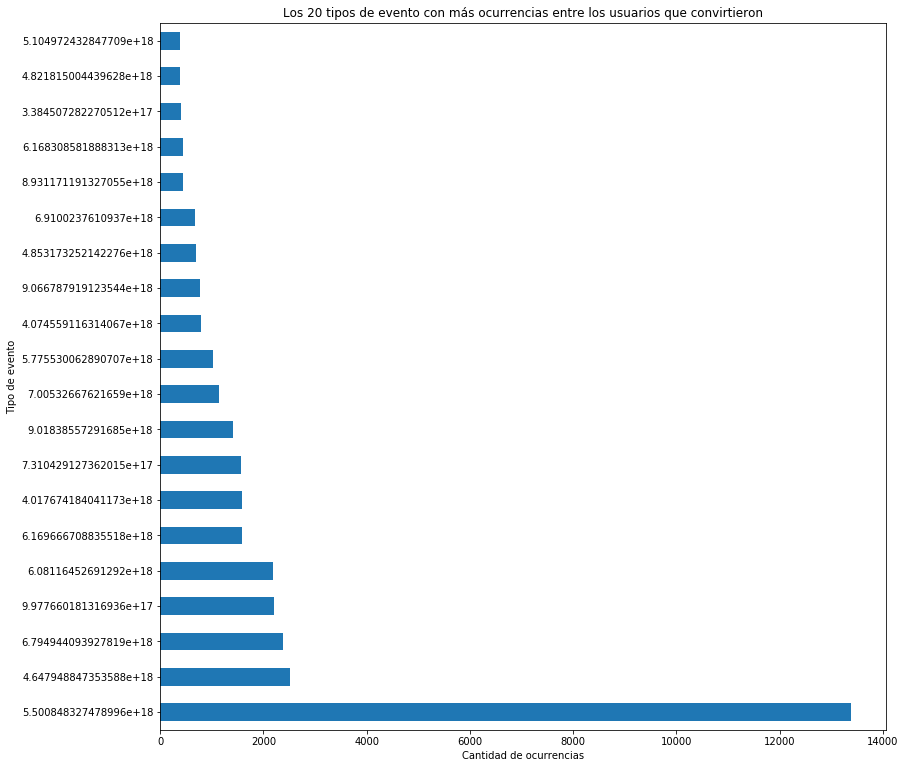

In [94]:
plot = agrup_tipos_evento_top20.plot(kind = 'barh', legend = False, figsize = (13,13))
plot.set_title("Los 20 tipos de evento con más ocurrencias entre los usuarios que convirtieron")
plot.set_xlabel("Cantidad de ocurrencias")  #fontdict = font para cambiar la fuente
plot.set_ylabel("Tipo de evento")

#### En promedio, ¿cuántos de ellos son atribuidos a Jampp? (no podemos realizar este análisis con los datos brindados)

In [100]:
events.loc[events['kind'].isin(list(agrup_tipos_evento_top20.index)),['attributed']]['attributed'].value_counts()

False    1640627
True           0
Name: attributed, dtype: int64

## ¿Cuáles fueron los 10 tipos de conversión que más usuarios atrayeron?

In [3]:
installs['cant'] = 1
kinds_group = installs.groupby('kind').agg({'cant':'count'})

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

In [9]:
kinds_group_ordered = kinds_group.sort_values(by = 'cant', ascending = False).reset_index().loc[:10]

Text(0, 0.5, 'Tipo de conversión')

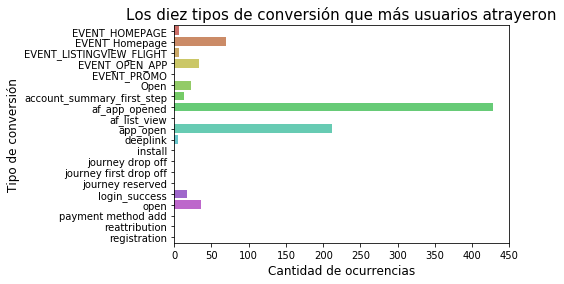

In [16]:
plot = sns.barplot(x= kinds_group_ordered['cant'], y = kinds_group_ordered['kind'], orient='h', palette="hls")
plot.set_title("Los diez tipos de conversión que más usuarios atrayeron", fontsize=15)
plot.set_xlabel("Cantidad de ocurrencias", fontsize=12)
plot.set_ylabel("Tipo de conversión", fontsize=12)

# Por qué aparecen otros tipos de instalación si esas filas no estan??!!